Setup and Install Dependencies: Ensure you have TensorFlow and other necessary libraries installed.

In [11]:
pip install tensorflow


Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 23.3.1 -> 24.1.2
[notice] To update, run: /Applications/Xcode.app/Contents/Developer/usr/bin/python3 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


Import Libraries:

In [12]:
import tensorflow as tf
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np

train_data_dir = '/Users/raysonyong/Documents/GitHub/csc3107-group26-p3-ml-brain-mri-classification/dataset_26'

Load Pre-trained DenseNet Model: Use DenseNet121, 169, or 201 as per your requirement. Here, we'll use DenseNet121.

In [13]:
# Load the DenseNet121 model pre-trained on ImageNet
base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the base model
for layer in base_model.layers:
    layer.trainable = False


Building Model

In [14]:
model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(4, activation='softmax')  # 4 classes: glioma, meningioma, no tumor, pituitary
])

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


Prepare Your Data: Use ImageDataGenerator for data augmentation.



In [15]:
# Data augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,  # Use 20% of the data for validation
    rotation_range=20,
    zoom_range=0.2,
    horizontal_flip=True
)

# Training and validation generators
train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='training'
)

validation_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='validation'
)

Found 384 images belonging to 4 classes.
Found 96 images belonging to 4 classes.


Train the model

In [16]:
# Train the model
history = model.fit(
    train_generator,
    epochs=25,
    validation_data=validation_generator
)


Epoch 1/25


/Users/raysonyong/Library/Python/3.9/lib/python/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


12/12 ━━━━━━━━━━━━━━━━━━━━ 25s 2s/step - accuracy: 0.3046 - loss: 1.8085 - val_accuracy: 0.5000 - val_loss: 1.2124
Epoch 2/25
12/12 ━━━━━━━━━━━━━━━━━━━━ 19s 2s/step - accuracy: 0.6155 - loss: 1.0077 - val_accuracy: 0.6667 - val_loss: 0.7790
Epoch 3/25
12/12 ━━━━━━━━━━━━━━━━━━━━ 20s 2s/step - accuracy: 0.7218 - loss: 0.6751 - val_accuracy: 0.7083 - val_loss: 0.7739
Epoch 4/25
12/12 ━━━━━━━━━━━━━━━━━━━━ 20s 2s/step - accuracy: 0.7807 - loss: 0.6118 - val_accuracy: 0.7396 - val_loss: 0.6792
Epoch 5/25
12/12 ━━━━━━━━━━━━━━━━━━━━ 20s 2s/step - accuracy: 0.7667 - loss: 0.5782 - val_accuracy: 0.7083 - val_loss: 0.6990
Epoch 6/25
12/12 ━━━━━━━━━━━━━━━━━━━━ 20s 2s/step - accuracy: 0.7454 - loss: 0.6124 - val_accuracy: 0.7917 - val_loss: 0.5780
Epoch 7/25
12/12 ━━━━━━━━━━━━━━━━━━━━ 22s 2s/step - accuracy: 0.8224 - loss: 0.4585 - val_accuracy: 0.8438 - val_loss: 0.5662
Epoch 8/25
12/12 ━━━━━━━━━━━━━━━━━━━━ 36s 3s/step - accuracy: 0.7984 - loss: 0.5039 - val_accuracy: 0.7500 - val_loss: 0.6055
Epo

Evaluate the model

3/3 ━━━━━━━━━━━━━━━━━━━━ 4s 1s/step - accuracy: 0.8555 - loss: 0.3599
Test accuracy: 0.84


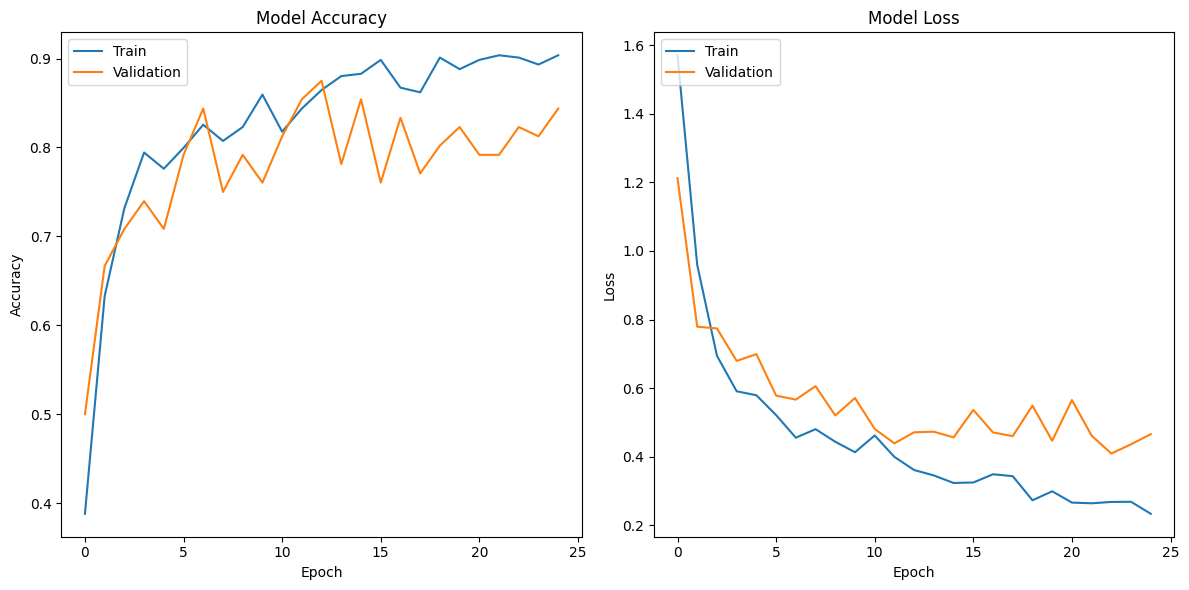

3/3 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step


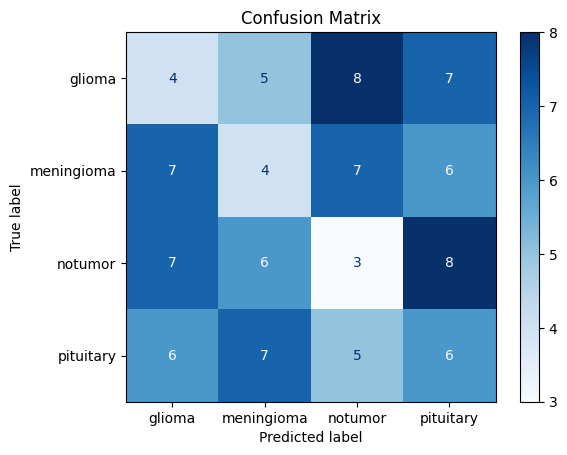

In [17]:

# Evaluate the model
test_loss, test_acc = model.evaluate(validation_generator)
print(f"Test accuracy: {test_acc:.2f}")

# Plotting accuracy and loss graphs
def plot_history(history):
    # Plot training & validation accuracy values
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')

    # Plot training & validation loss values
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')

    plt.tight_layout()
    plt.show()

# Call the function to plot the graphs
plot_history(history)

# Confusion matrix
def plot_confusion_matrix(model, validation_generator):
    # Predict the values from the validation dataset
    Y_pred = model.predict(validation_generator)
    # Convert predictions classes to one hot vectors
    Y_pred_classes = np.argmax(Y_pred, axis=1)
    # Convert validation observations to one hot vectors
    Y_true = validation_generator.classes
    # Compute the confusion matrix
    cm = confusion_matrix(Y_true, Y_pred_classes)
    # Display the confusion matrix
    cm_display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=validation_generator.class_indices.keys())
    cm_display.plot(cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.show()

# Call the function to plot the confusion matrix
plot_confusion_matrix(model, validation_generator)